In [26]:
import pandas as pd
import numpy as np
from math import exp
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import label_binarize
#from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#CCLE data for pharmacologic sensitivity profile
Drug_Response_Table = pd.read_csv("../drugResponse/CCLE_NP24.2009_Drug_data_2015.02.24.csv", index_col=0) #Target genes also in Pathway Data - {'ALK', 'CDK4', 'EGFR', 'IGF1R', 'MDM2'}
#CCLE mapping from genes to cell line names
Expression_Cell_Line = pd.read_csv("../drugResponse/CCLE_Expression_Entrez_2012-09-29.gct",sep='\t', index_col=1)
Expression_Cell_Line = pd.DataFrame(sp.stats.zscore(Expression_Cell_Line.loc[:,Drug_Response_Table.index]) , index=Expression_Cell_Line.index, columns=Drug_Response_Table.index)

In [4]:
#read tumor table
TumorSample_table = pd.read_csv("../EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena",sep='\t', index_col=0)
TumorSample_table = TumorSample_table.dropna()

In [5]:
#read curated pathway templates, descriptions of pathways
CELL_CYCLE_Table = pd.read_csv("../curated/curated_pathway_templates.Cell_Cycle.tsv",sep='\t', index_col=0)
HIPPO_Table = pd.read_csv("../curated/curated_pathway_templates.HIPPO.tsv",sep='\t', index_col=0)
MYC_Table = pd.read_csv("../curated/curated_pathway_templates.MYC.tsv",sep='\t', index_col=0)
NOTCH_Table = pd.read_csv("../curated/curated_pathway_templates.NOTCH.tsv",sep='\t', index_col=0)
NRF2_Table = pd.read_csv("../curated/curated_pathway_templates.NRF2.tsv",sep='\t', index_col=0)
PI3K_Table = pd.read_csv("../curated/curated_pathway_templates.PI3K.tsv",sep='\t', index_col=0)
RTK_RAS_Table = pd.read_csv("../curated/curated_pathway_templates.RTK_RAS.tsv",sep='\t', index_col=0)
TGF_BETA_Table = pd.read_csv("../curated/curated_pathway_templates.TGF-Beta.tsv",sep='\t', index_col=0)
TP53_Table = pd.read_csv("../curated/curated_pathway_templates.TP53.tsv",sep='\t', index_col=0)
WNT_Table = pd.read_csv("../curated/curated_pathway_templates.WNT.tsv",sep='\t', index_col=0)

#alteration table, binaries indicating pathway
Alteration_Level_table = pd.read_csv("../alterations/genomic_alteration_matrices.Alteration_level.tsv",sep='\t', index_col=0)
Gene_Alteration = pd.read_csv("../alterations/genomic_alteration_matrices.Gene_level.tsv",sep='\t', index_col=0)
Pathway_Alteration = pd.read_csv("../alterations/genomic_alteration_matrices.Pathway_level.tsv",sep='\t', index_col=0)

#cleaning pathway alteration table
Pathway_Alteration = Pathway_Alteration.dropna()
Pathway_Alteration = Pathway_Alteration.astype(int)

In [6]:
#read reactome pathway : gene collections 
list_of_all_pathways = {}

with open("../pathways/Human_Reactome_July_05_2019_symbol.gmt") as f:
    for line in f:
        full_gene_set = line.strip().split("\t")
        list_of_all_pathways[full_gene_set[0]] = full_gene_set[2:]

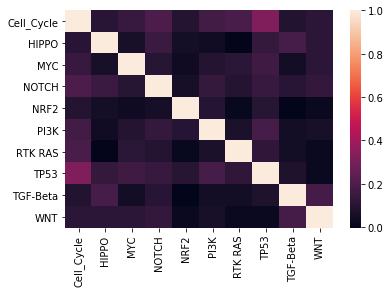

In [7]:
#pathway correlation matrix
corr = Pathway_Alteration.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [8]:
###TCGA DATASETS###

#Copy Number Variance (CNV) tables ## -1 -> deletion, 0 -> normal, 1 -> overexpressed
CNV_Threshold = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/copy_number_variance/CNV_Threshold",sep='\t', index_col=0) ## what do 0,1,2 mean


#Methylation tables
Methylation_Table = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/methylation/HumanMethylation27",sep='\t', index_col=0)
Methylation_Mapping = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/methylation/illuminaMethyl27K_hg18_gpl8490_TCGAlegacy",sep='\t', index_col=0)

genes = list(set(Methylation_Mapping.index).intersection(set(Methylation_Table.index)))     #map gene ids to gene code
a = dict()
for id in Methylation_Mapping.index:
    a.update({id:Methylation_Mapping.loc[id,"gene"]})
Methylation_Table = Methylation_Table.rename(a).dropna()
Methylation_Table = Methylation_Table.loc[~Methylation_Table.index.duplicated(),:]

#Tumor Sample to Cancer cohort mapping
Sample_Cancer_Mapping = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/sample_cancer_cohort.txt" ,sep='\t', index_col=0)

#TCGA Protein expression data 
Protein_Expression_Table = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/protein_expression/TCGA-RPPA-pancan-clean.xena" ,sep='\t', index_col=0)

#Paradigm score table for validation purposes
Paradigm_Pathway_Score = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/paradigm_pathway_activity.txt", sep="\t",index_col=0) 

#Somatic Mutations 
Somatic_Mutation_Table = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/somatic_mutation/mc3.v0.2.8.PUBLIC.nonsilentGene.xena",sep='\t', index_col=0)
Somatic_Mutation_Mapping = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/somatic_mutation/hugo_gencode_good_hg19_V24lift37_probemap",sep='\t', index_col=0)

In [9]:
#mapping of tumor sample to cancer types to see if predictive ability is dependent on type of cancer
Cancer_mapping = pd.read_csv("../tcga/Survival_SupplementalTable_S1_20171025_xena_sp",sep='\t', index_col=0)

patients = list(set(TumorSample_table.columns).intersection(set(Cancer_mapping.index)))     #map gene ids to gene code
cancer_type = dict()
for patient in patients:
    cancer_type.update({patient:Cancer_mapping.loc[patient,"cancer type abbreviation"]})
subtype_to_patient = {n:[k for k in cancer_type.keys() if cancer_type[k] == n] for n in set(cancer_type.values())}
subtype_to_patient.pop('LAML')

['TCGA-AB-2913-03',
 'TCGA-AB-2912-03',
 'TCGA-AB-2924-03',
 'TCGA-AB-2987-03',
 'TCGA-AB-2999-03',
 'TCGA-AB-2976-03',
 'TCGA-AB-2964-03',
 'TCGA-AB-3002-03',
 'TCGA-AB-2863-03',
 'TCGA-AB-2824-03',
 'TCGA-AB-2860-03',
 'TCGA-AB-2996-03',
 'TCGA-AB-2815-03',
 'TCGA-AB-2973-03',
 'TCGA-AB-2895-03',
 'TCGA-AB-2935-03',
 'TCGA-AB-2950-03',
 'TCGA-AB-3005-03',
 'TCGA-AB-2942-03',
 'TCGA-AB-2984-03',
 'TCGA-AB-2867-03',
 'TCGA-AB-2855-03',
 'TCGA-AB-2819-03',
 'TCGA-AB-2925-03',
 'TCGA-AB-2838-03',
 'TCGA-AB-2966-03',
 'TCGA-AB-2868-03',
 'TCGA-AB-2832-03',
 'TCGA-AB-2847-03',
 'TCGA-AB-3012-03',
 'TCGA-AB-2870-03',
 'TCGA-AB-2869-03',
 'TCGA-AB-3007-03',
 'TCGA-AB-2917-03',
 'TCGA-AB-2837-03',
 'TCGA-AB-2823-03',
 'TCGA-AB-2991-03',
 'TCGA-AB-2896-03',
 'TCGA-AB-2934-03',
 'TCGA-AB-3001-03',
 'TCGA-AB-2821-03',
 'TCGA-AB-2812-03',
 'TCGA-AB-2898-03',
 'TCGA-AB-2970-03',
 'TCGA-AB-2810-03',
 'TCGA-AB-2909-03',
 'TCGA-AB-2828-03',
 'TCGA-AB-2975-03',
 'TCGA-AB-2851-03',
 'TCGA-AB-2880-03',


In [10]:
#Get influential genes-set listed under each of 10 pathways, based on curated template
CELL_CYCLE = tuple(set(CELL_CYCLE_Table.index).intersection(set(TumorSample_table.index))) #15 original curated genes, 0 lost due to NA
HIPPO  = tuple(set(HIPPO_Table.index).intersection(set(TumorSample_table.index)))          #38 original curated genes,  3 lost due to NA
MYC = tuple(set(MYC_Table.index).intersection(set(TumorSample_table.index)))               #13 original curated genes, 1 lost due to NA
NOTCH = tuple(set(NOTCH_Table.index).intersection(set(TumorSample_table.index)))           #71 original curated genes, 5 lost due to NA
NRF2 = tuple(set(NRF2_Table.index).intersection(set(TumorSample_table.index)))             #3 original curated genes, 0 lost due to NA
PI3K = tuple(set(PI3K_Table.index).intersection(set(TumorSample_table.index)))             #29 original curated genes, 1 lost due to NA
RTK_RAS = tuple(set(RTK_RAS_Table.index).intersection(set(TumorSample_table.index)))       #84 original curated genes, 5 lost due to NA
TGF_BETA = tuple(set(TGF_BETA_Table.index).intersection(set(TumorSample_table.index)))     #7 original curated genes, 0 lost due to NA
TP53 = tuple(set(TP53_Table.index).intersection(set(TumorSample_table.index)))             #6 original curated genes, 0 lost due to NA
WNT = tuple(set(WNT_Table.index).intersection(set(TumorSample_table.index)))               #68 original curated genes, 10 lost due to NA
ALL_PATHWAY_GENES = sum((CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT), ())
PATHWAYS = [CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT]


#onco gene (OG) or tumor supressor (TSG)
#for each pathway, create a dict with key = (pathway, gene) -> value = OG or TSG
OG_TSG = {}
pathway_index = 0
pathway_to_table = {0 :CELL_CYCLE_Table , 1 : HIPPO_Table , 2 : MYC_Table , 3 : NOTCH_Table , 4 : NRF2_Table , 
                    5 : PI3K_Table, 6 : RTK_RAS_Table , 7 : TGF_BETA_Table , 8 : TP53_Table, 9 : WNT_Table}

for pathway in [CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT]:
    for gene in pathway:
        if (pathway_to_table[pathway_index].loc[[gene],['OG/TSG']] == 'OG').bool():
            OG_TSG[gene] = 'OG'
        else:
            OG_TSG[gene] = 'TSG'
    pathway_index += 1

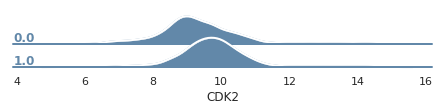

In [11]:
###distribution for genes and pathway activity###
#Pathway_Alteration.hist()
patients = set(TumorSample_table.columns).intersection(set(Pathway_Alteration.index))
df = TumorSample_table.loc[CELL_CYCLE,patients].append(Pathway_Alteration.loc[patients,:].T)
df = df.T

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(1, rot=-.2, light=.5)
g = sns.FacetGrid(df, row="Cell_Cycle", hue="Cell_Cycle", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "CDK2", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "CDK2", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "CDK2")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

sns_plot = g
#sns_plot.savefig("output10.png")

In [12]:
#calculate pathway activation score based on sigmoid/ y-reflected sigmoid based on TSG or OG expression. 
#sigmoid(x) where x = z-score(gene expression)
for gene in ALL_PATHWAY_GENES:
        if OG_TSG[gene] == 'TSG':            
            TumorSample_table.loc[gene, :] = 1/(1+np.vectorize(exp)(( 2 * sp.stats.zscore(TumorSample_table.loc[gene, :])))*3) #TSG, y-axis reflected signmoid
            if gene in set(ALL_PATHWAY_GENES).intersection(set(Expression_Cell_Line.index)):
                Expression_Cell_Line.loc[gene,:] *= -1 
        else:
            TumorSample_table.loc[gene, :] = 1/(1+(np.vectorize(exp)((-2* sp.stats.zscore(TumorSample_table.loc[gene, :]))))*3) #OG, sigmoid        
            
patients = list(set(CNV_Threshold.columns).intersection(set(TumorSample_table.columns)).intersection(set(Somatic_Mutation_Table.columns)))#.intersection(set(Methylation_Table.columns)))
genes = list(set(ALL_PATHWAY_GENES).intersection(set(CNV_Threshold.index)).intersection(set(TumorSample_table.index)).intersection(set(Somatic_Mutation_Table.index)))#.intersection(set(Methylation_Table.index))) 
TumorSample_table = TumorSample_table.loc[genes,patients] + (.5 * CNV_Threshold.loc[genes,patients].T.multiply(np.array(TumorSample_table.loc[genes,patients].std(axis=1)),axis=1)).T + (.5 * (Somatic_Mutation_Table.loc[genes,patients].T.multiply(np.array(TumorSample_table.loc[genes,patients].std(axis=1)),axis=1)).T) #- ((Methylation_Table.loc[genes,patients].T.multiply(np.array(TumorSample_table.loc[genes,patients].std(axis=1)),axis=1)).T)            

In [21]:
#Drug response data per individual pathways,
#data frames containing actArea scores of each pathway, used to return
CELL_CYCLE_Targeted = Expression_Cell_Line.loc[CELL_CYCLE, :].mean(axis=0)
HIPPO_Targeted = Expression_Cell_Line.loc[HIPPO, :].mean(axis=0)
MYC_Targeted = Expression_Cell_Line.loc[MYC, :].mean(axis=0)
NOTCH_Targeted = Expression_Cell_Line.loc[NOTCH, :].mean(axis=0)
NRF2_Targeted = Expression_Cell_Line.loc[NRF2, :].mean(axis=0)
PI3K_Targeted = Expression_Cell_Line.loc[PI3K, :].mean(axis=0)
RTK_RAS_Targeted = Expression_Cell_Line.loc[RTK_RAS, :].mean(axis=0)
TGF_BETA_Targeted = Expression_Cell_Line.loc[TGF_BETA, :].mean(axis=0)
TP53_Targeted = Expression_Cell_Line.loc[TP53, :].mean(axis=0)
WNT_Targeted = Expression_Cell_Line.loc[WNT, :].mean(axis=0)

##Get row of CCLE pharmacological profiles to recommend therapeutics

#Drug_Response_Table[Drug_Response_Table['ActArea'] == Drug_Response_Table.loc[CELL_CYCLE_Targeted.nlargest(4).index[0],'ActArea'].max()]
#Expression_Cell_Line.loc[CELL_CYCLE, :]
#df[df['date'] == df['date'].max()]
#Drug_Response_Table
#pd.DataFrame(CELL_CYCLE_Targeted)

In [14]:
#Obtain pathway score by averaging patient's gene expression scores for each pathway table
CELL_CYCLE_Score = TumorSample_table.loc[CELL_CYCLE, :].mean(axis=0)
HIPPO_Score = TumorSample_table.loc[HIPPO, :].mean(axis=0)
MYC_Score = TumorSample_table.loc[MYC, :].mean(axis=0)
NOTCH_Score = TumorSample_table.loc[NOTCH, :].mean(axis=0)
NRF2_Score = TumorSample_table.loc[NRF2, :].mean(axis=0)
PI3K_Score = TumorSample_table.loc[PI3K, :].mean(axis=0)
RTK_RAS_Score = TumorSample_table.loc[RTK_RAS, :].mean(axis=0)
TGF_BETA_Score = TumorSample_table.loc[TGF_BETA, :].mean(axis=0)
TP53_Score = TumorSample_table.loc[TP53, :].mean(axis=0)
WNT_Score = TumorSample_table.loc[WNT, :].mean(axis=0)

#Compile patient pathway score for each pathway
Patient_Pathway_Score_Table = pd.concat([CELL_CYCLE_Score ,HIPPO_Score, MYC_Score, NOTCH_Score, NRF2_Score, PI3K_Score, RTK_RAS_Score,  TP53_Score,TGF_BETA_Score, WNT_Score], axis=1)
Patient_Pathway_Score_Table.columns = ["Cell_Cycle" ,"HIPPO", "MYC", "NOTCH", "NRF2", "PI3K", "RTK RAS", "TGF-Beta", "TP53", "WNT"]

#get common patients for validation purposes
Patient_Pathway_Score_Table = Patient_Pathway_Score_Table.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]
Pathway_Alteration = Pathway_Alteration.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]

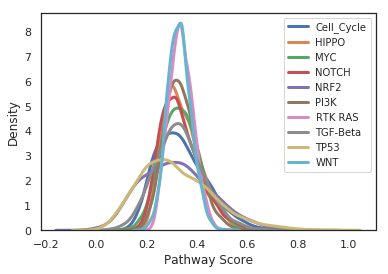

In [15]:
#plot of score distributions for threshold determination
Pathways = Patient_Pathway_Score_Table.columns

for pathway in Pathways:
    subset = Patient_Pathway_Score_Table.loc[:,pathway]
    
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label=pathway)
    
plt.legend(prop={'size': 10}, facecolor='white')
plt.xlabel('Pathway Score')
plt.ylabel('Density')
#plt.show()
plt.savefig('./density.png')

In [16]:
#Obtain pathway score by averaging patient's gene expression for each pathway table
CELL_CYCLE_Score = TumorSample_table.loc[CELL_CYCLE, :].mean(axis=0)
HIPPO_Score = TumorSample_table.loc[HIPPO, :].mean(axis=0)
MYC_Score = TumorSample_table.loc[MYC, :].mean(axis=0)
NOTCH_Score = TumorSample_table.loc[NOTCH, :].mean(axis=0)
NRF2_Score = TumorSample_table.loc[NRF2, :].mean(axis=0)
PI3K_Score = TumorSample_table.loc[PI3K, :].mean(axis=0)
RTK_RAS_Score = TumorSample_table.loc[RTK_RAS, :].mean(axis=0)
TGF_BETA_Score = TumorSample_table.loc[TGF_BETA, :].mean(axis=0)
TP53_Score = TumorSample_table.loc[TP53, :].mean(axis=0)
WNT_Score = TumorSample_table.loc[WNT, :].mean(axis=0)

#Compile patient pathway score for each pathway
Patient_Pathway_Score_Table = pd.concat([CELL_CYCLE_Score ,HIPPO_Score, MYC_Score, NOTCH_Score, NRF2_Score, PI3K_Score, RTK_RAS_Score,  TP53_Score,TGF_BETA_Score, WNT_Score], axis=1)
Patient_Pathway_Score_Table.columns = ["Cell_Cycle" ,"HIPPO", "MYC", "NOTCH", "NRF2", "PI3K", "RTK RAS", "TGF-Beta", "TP53", "WNT"]

Patient_Pathway_Score_Table = Patient_Pathway_Score_Table.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]
Pathway_Alteration = Pathway_Alteration.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]

patient_prediction_error = []
pathway_prediction_error = []
Patient_Pathway_Score_Table = Patient_Pathway_Score_Table.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]
Pathway_Alteration = Pathway_Alteration.loc[set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)),:]

#Set threshold to convert sigmoid into 0 or 1
#predict yes for values greater than 1 standard deviations above the mean

for pathway in Patient_Pathway_Score_Table.columns:
    for patient in Patient_Pathway_Score_Table.index:
        pathway_mean = Patient_Pathway_Score_Table.loc[:, pathway].mean(axis=0)
        pathway_sd = Patient_Pathway_Score_Table.loc[:, pathway].std(axis=0)
        if Patient_Pathway_Score_Table.loc[patient, pathway] >  .3: #pathway_mean + 2 * pathway_sd:
            Patient_Pathway_Score_Table.loc[patient, pathway] = 1
        else: Patient_Pathway_Score_Table.loc[patient, pathway] = 0
Patient_Pathway_Score_Table = Patient_Pathway_Score_Table.astype(int)

#calculate error in predicting an individual patient's pathway activity level                       
for patient in Patient_Pathway_Score_Table.index:
    patient_prediction_error.append(np.mean(np.array(Patient_Pathway_Score_Table.loc[patient]) != np.array(Pathway_Alteration.loc[patient])))

#calculate average error for each pathway

In [17]:
#dict of cancer type : dataframe of patients' scores with cancer type
for key in subtype_to_patient.keys():
    subtype_to_patient.update({key : Patient_Pathway_Score_Table.loc[list(set(subtype_to_patient[key]).intersection(set(Patient_Pathway_Score_Table.index))),:]})

In [27]:
def ROC(df):    
    #Plot ROC for each pathway
    n_classes = Patient_Pathway_Score_Table.columns
    #patients = Patient_Pathway_Score_Table.index
    patients = list(set(df.index).intersection(set(Patient_Pathway_Score_Table.index)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in n_classes:
        fpr[i], tpr[i], _ = roc_curve(np.array(Pathway_Alteration.loc[patients,i]) , np.array(Patient_Pathway_Score_Table.loc[patients,i]))
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(Pathway_Alteration.loc[patients,i]),  np.array(Patient_Pathway_Score_Table.loc[patients,i]).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in n_classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in n_classes:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(n_classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    plt.figure(figsize=(10, 10))

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'magenta', 'black', 'yellow', 'firebrick', 'red', 'pink'])
    for i, color in zip(n_classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pathway ROC')
    plt.legend(loc="lower right", facecolor='white')
    plt.show()
    return roc_auc
    #plt.savefig("./outputCAT.jpg")

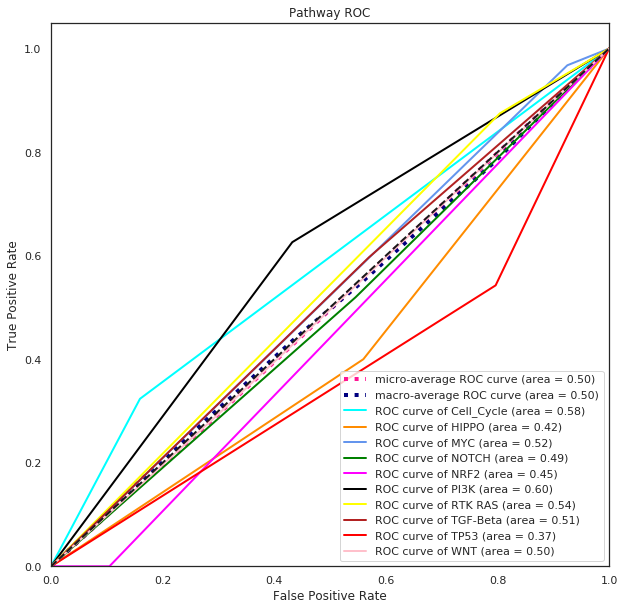

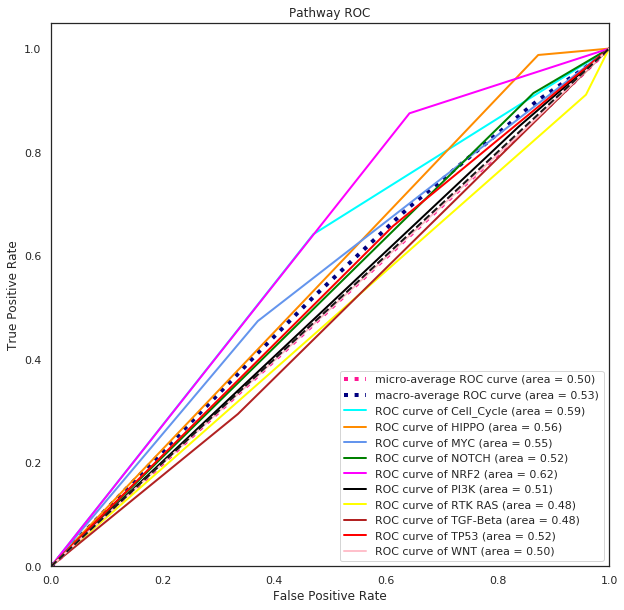

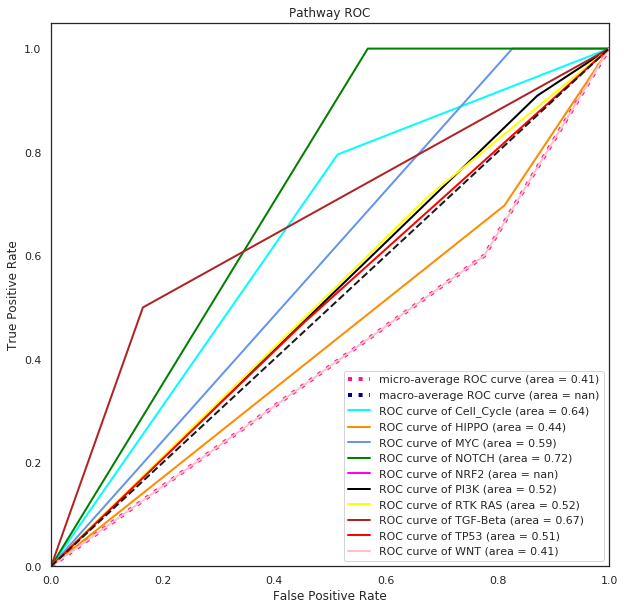

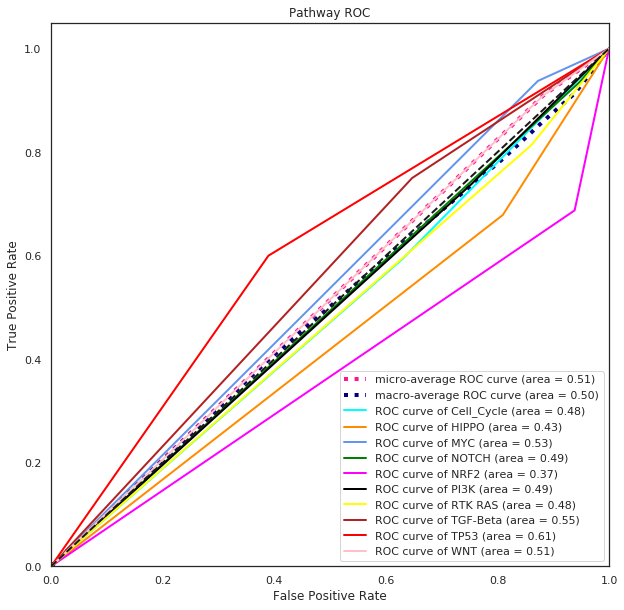

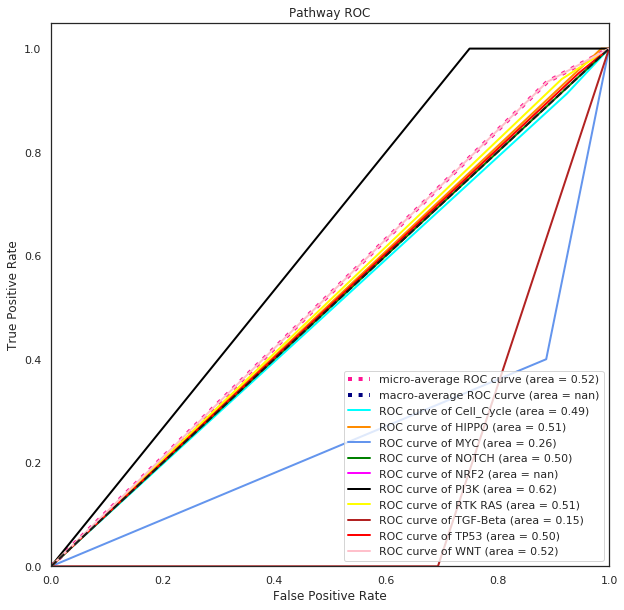

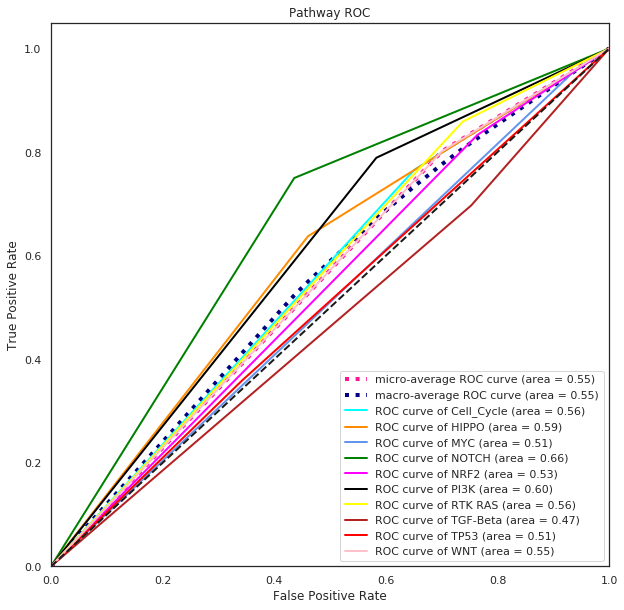

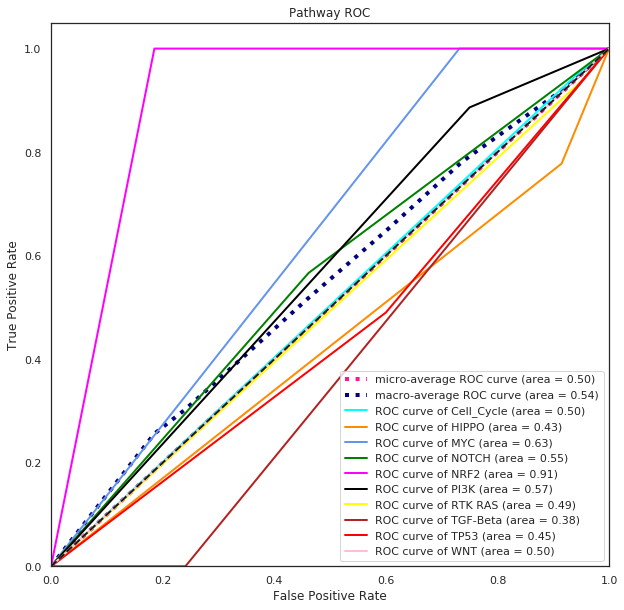

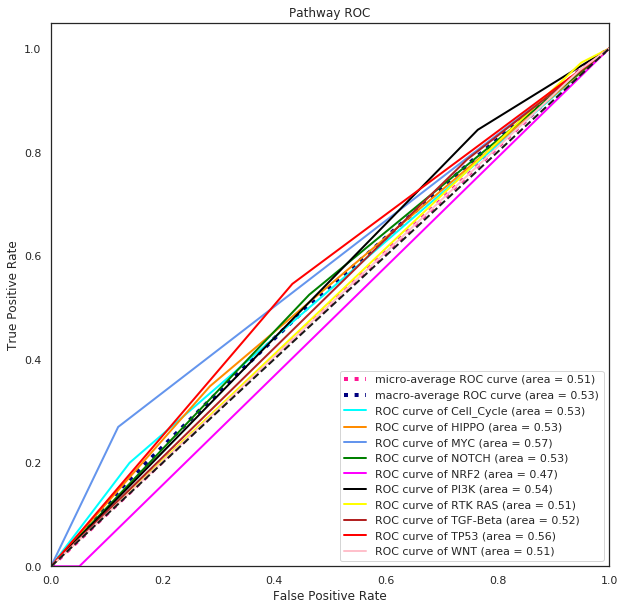

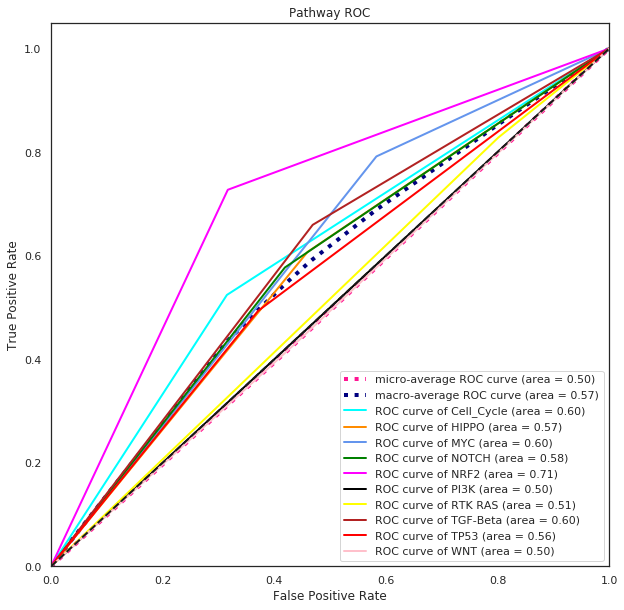

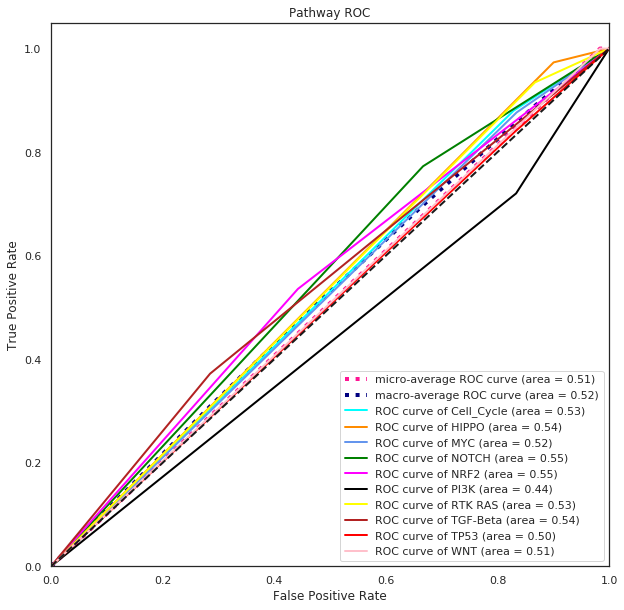

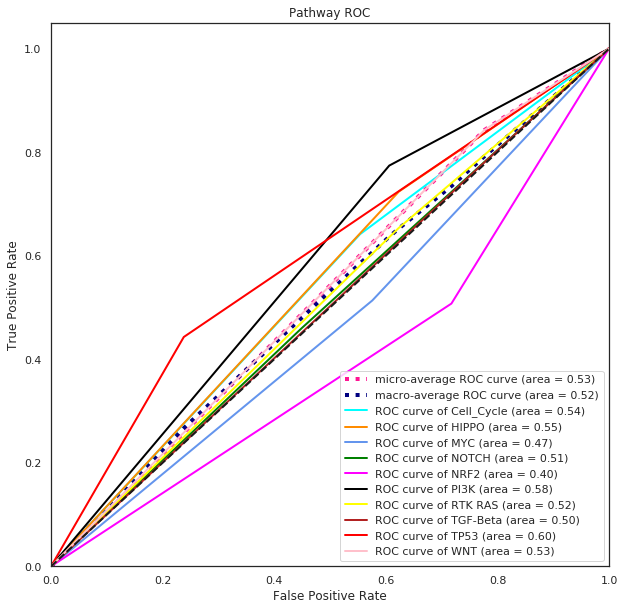

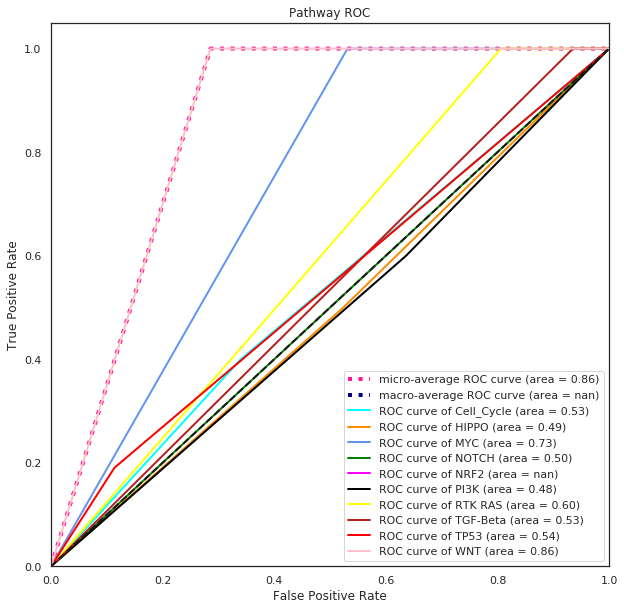

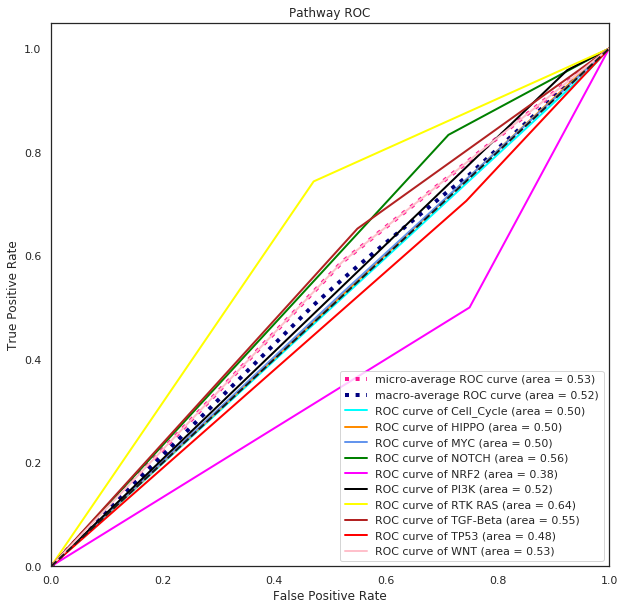

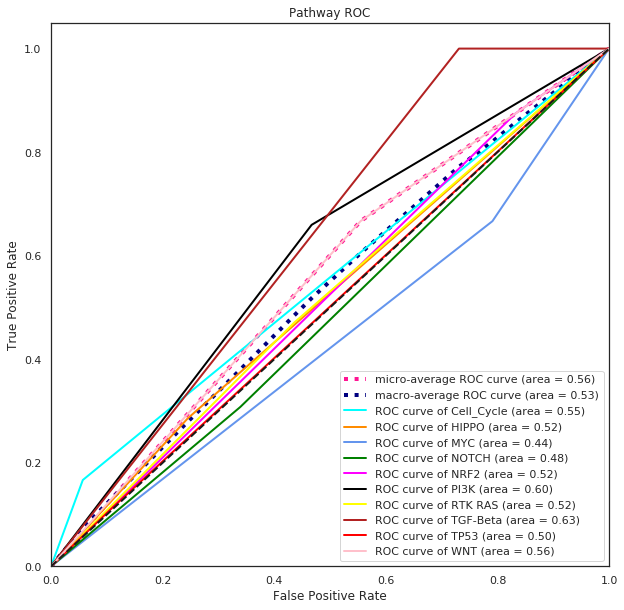

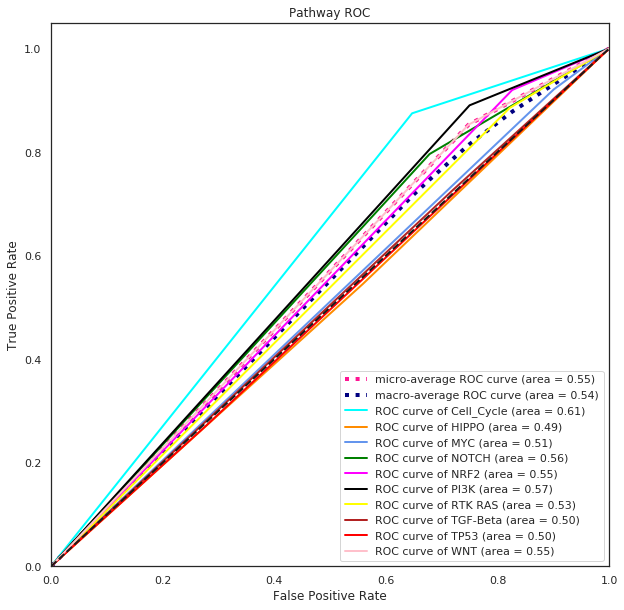

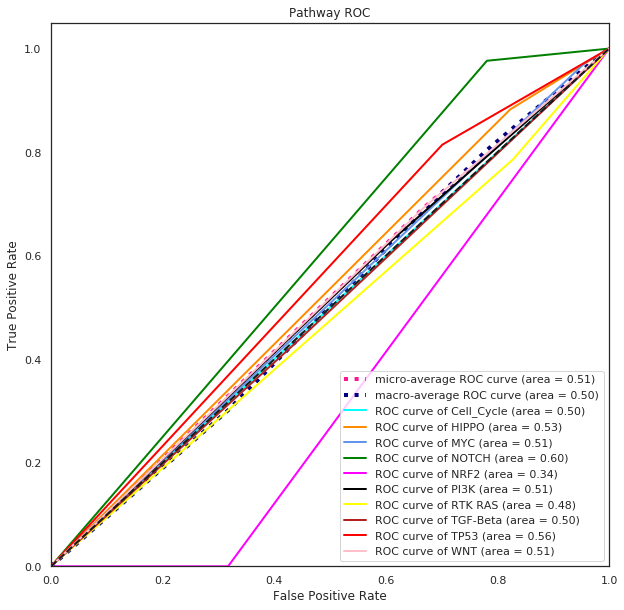

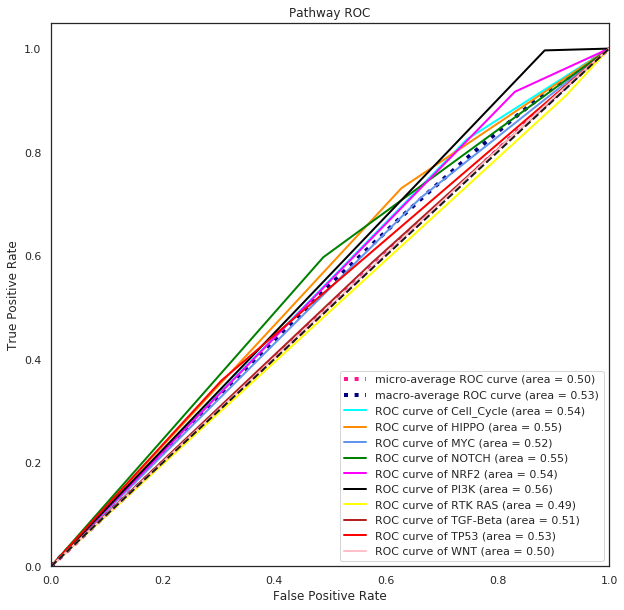

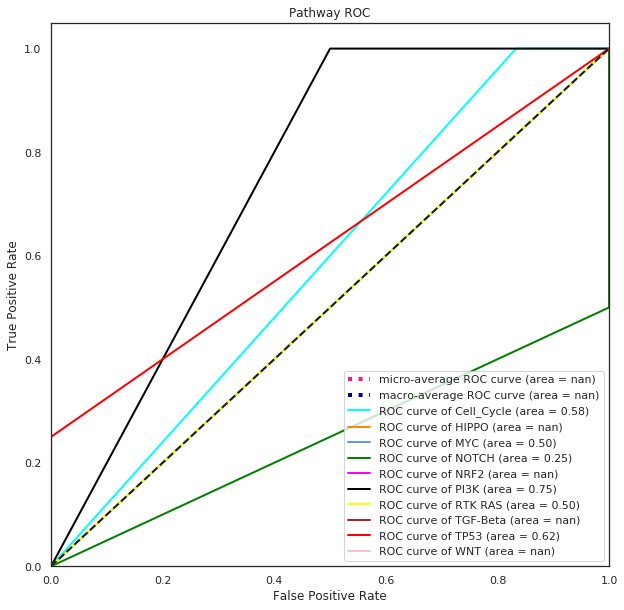

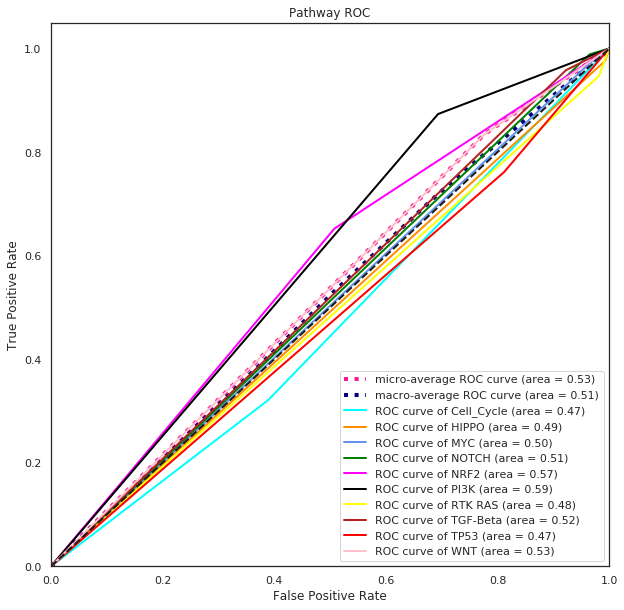

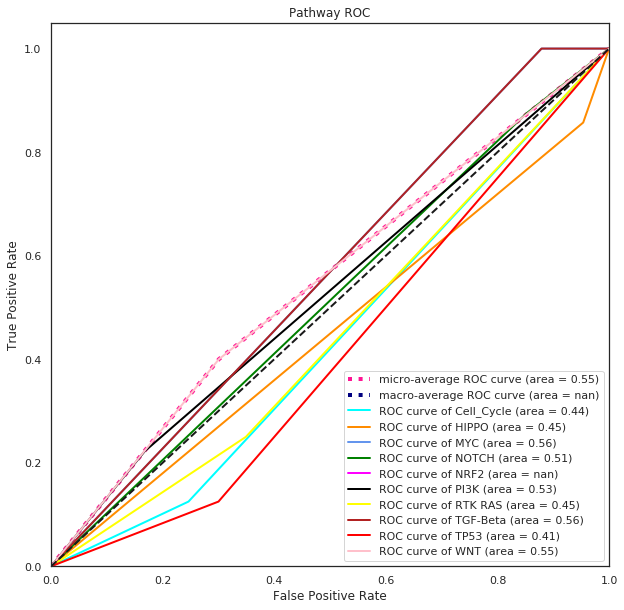

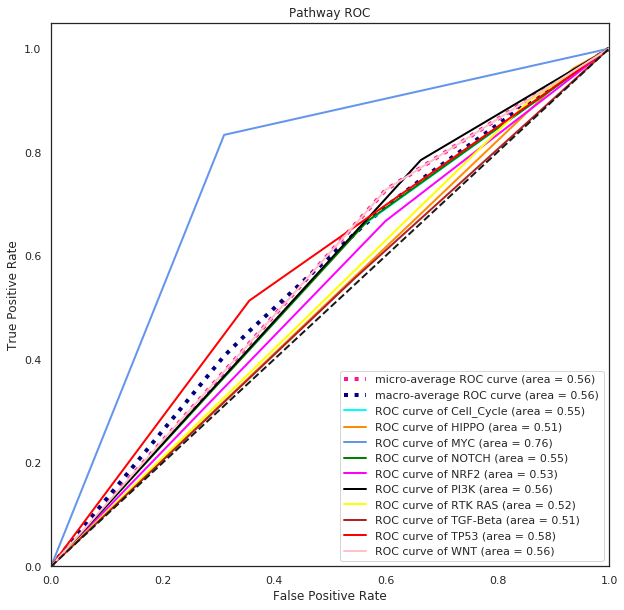

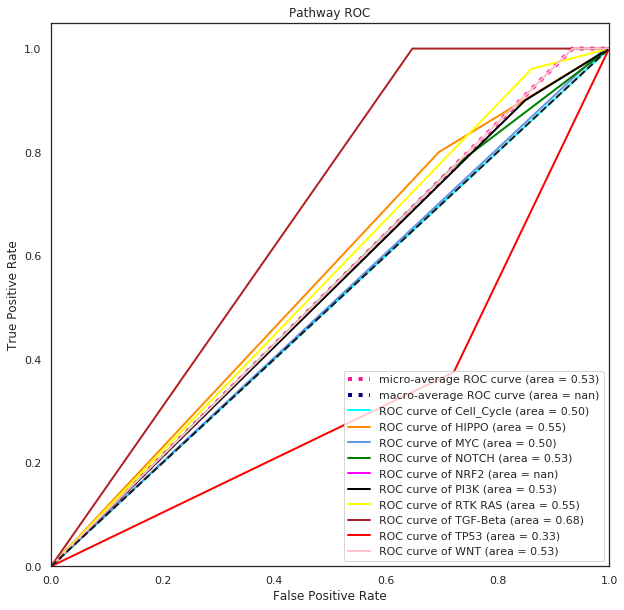

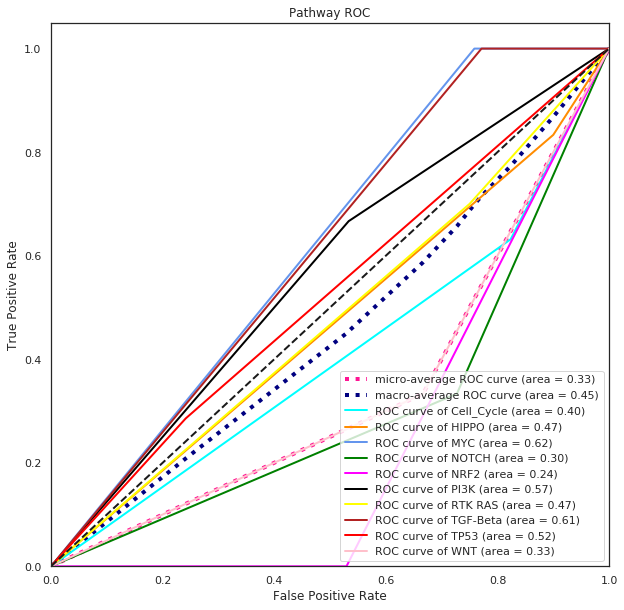

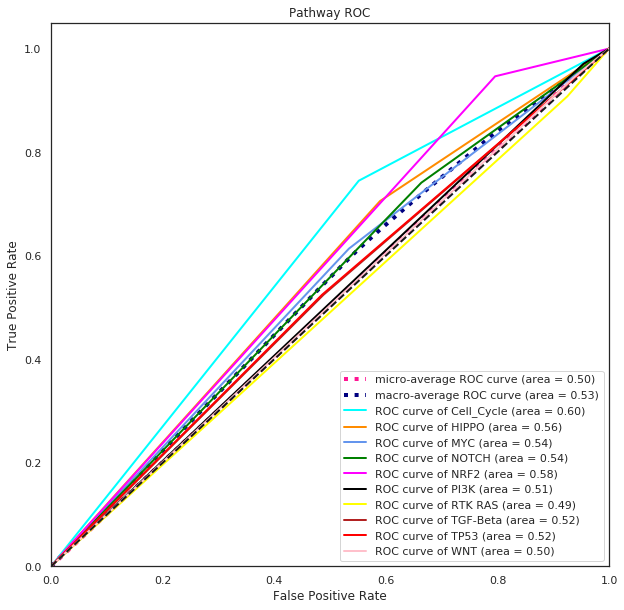

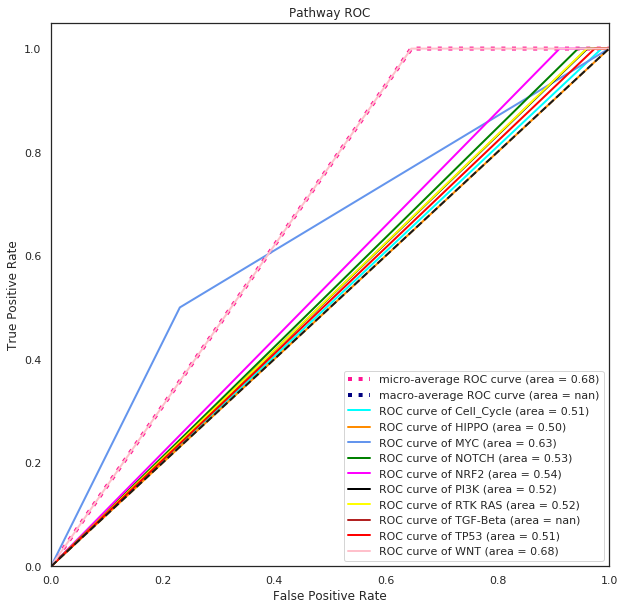

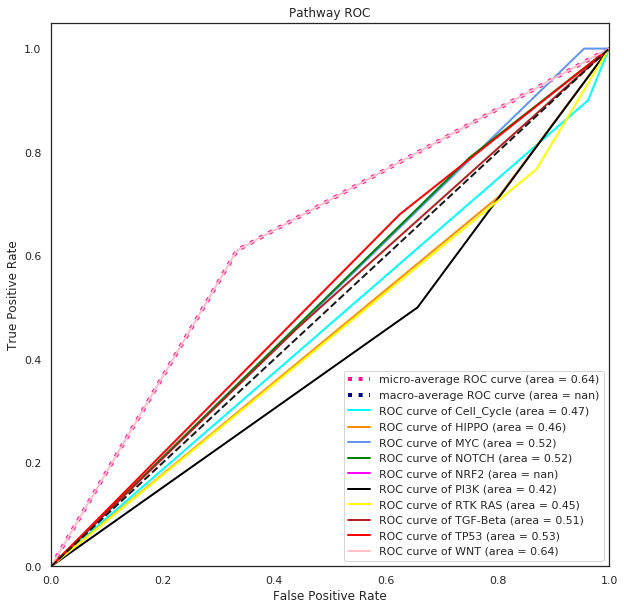

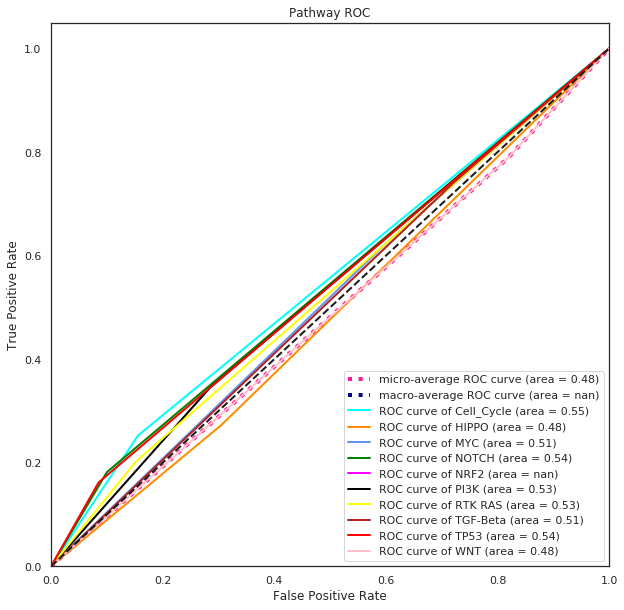

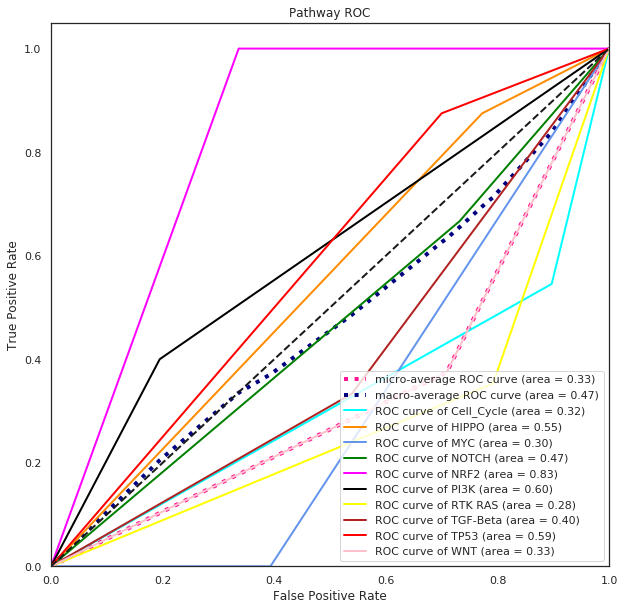

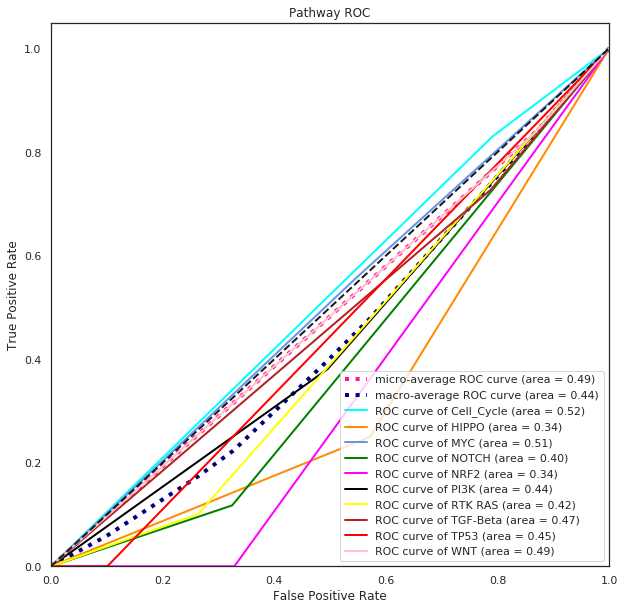

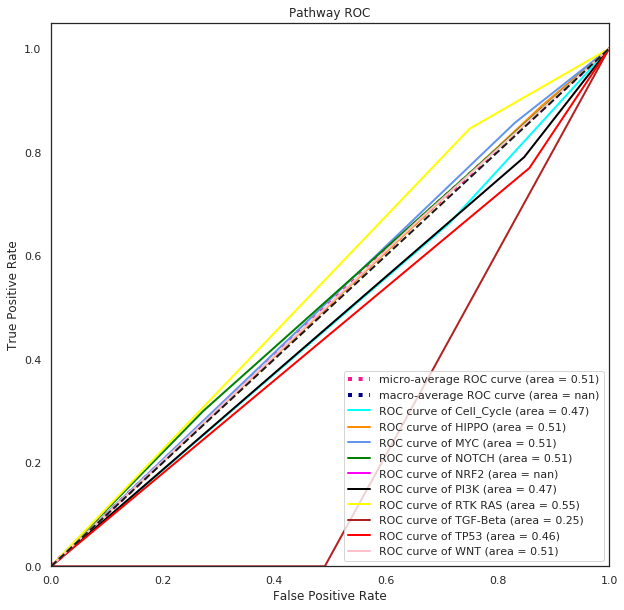

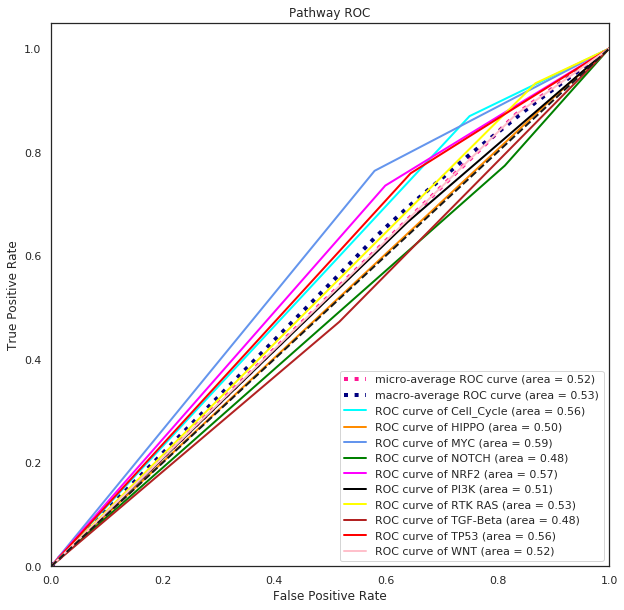

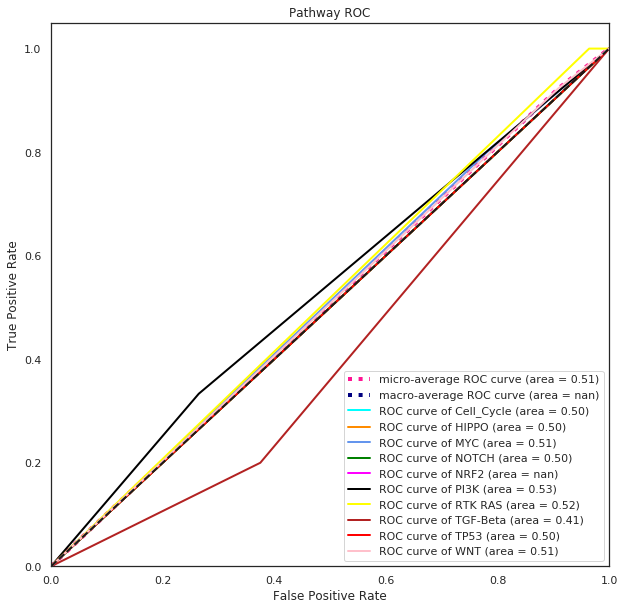

In [28]:
a = []
for key in subtype_to_patient.keys():
    a.append(list(ROC(subtype_to_patient[key].dropna()).values()))

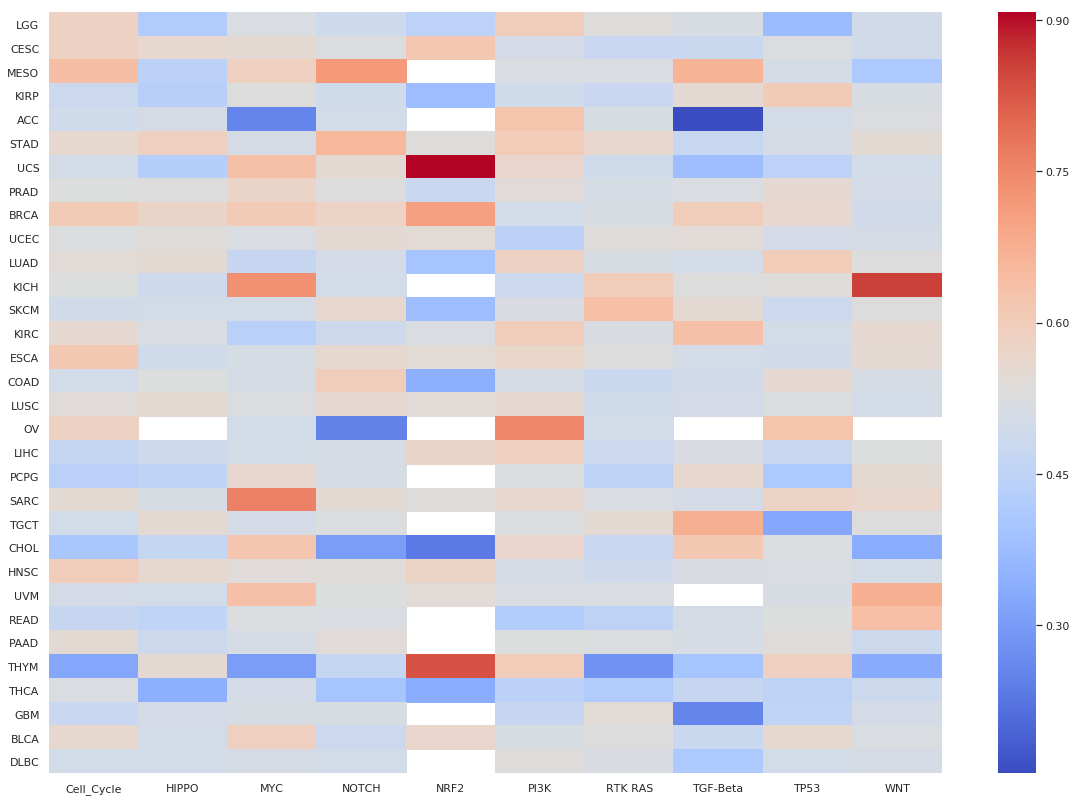

In [29]:
q = [np.array(x[0:10]) for x in a]
df = pd.DataFrame(q, columns=Patient_Pathway_Score_Table.columns, index=list(subtype_to_patient.keys()))

plt.figure(figsize=(20, 14))
sns_plot = sns.heatmap(df, cmap='coolwarm')

In [ ]:
#overall accuracy
sum(sum(np.array(Patient_Pathway_Score_Table == Pathway_Alteration.loc[Patient_Pathway_Score_Table.index, Patient_Pathway_Score_Table.columns])))/(Patient_Pathway_Score_Table.shape[0] * Patient_Pathway_Score_Table.shape[1])

In [ ]:
# for patient in set(Pathway_Alteration.index).intersection(set(Patient_Pathway_Score_Table.index)):
confusion_matrix = pd.DataFrame()    
for pathway in Pathway_Alteration.columns:
    a = pd.Series(Pathway_Alteration[pathway], name='Actual_' + pathway)
    b = pd.Series(Patient_Pathway_Score_Table[pathway], name = 'Predicted_' + pathway)
    cm = pd.crosstab(a,b,rownames=['Predicted'])
    confusion_matrix = pd.concat([cm , confusion_matrix])

        
confusion_matrix = (confusion_matrix.T.set_index(np.repeat('Actual', confusion_matrix.shape[1]), append=True).T)
pd.concat([confusion_matrix] ,keys=("Cell_Cycle" ,"HIPPO", "MYC", "NOTCH", "NRF2", "PI3K", "RTK RAS", "TGF-Beta", "TP53", "WNT"))    

#balanced accuracy, prediction at about 50/50
accuracy = pd.DataFrame()
accuracy = pd.concat([confusion_matrix.T.apply(lambda x: x/sum(x)).T, accuracy], axis=1)/2

HTML('''
        <style>
            .accuracy tbody tr:nth-child(even) { background-color: lightblue; }
        </style>
        ''' + accuracy.to_html(classes="accuracy"))